## 1 Anomaly detection

这部分，您将实现一个异常检测算法来检测服务器计算机中的异常行为。他的特征是测量每个服务器的响应速度(mb/s)和延迟(ms)。当你的服务器运行时，你收集到了m=307的样本，是无标签的。你相信其中绝大多数样本是正常的，但还是有一小部分的样本是异常的。

我们将使用高斯分布模型来检测数据集中的异常样本。

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [8]:
mat = loadmat('data/ex8data1.mat')
print(mat.keys())
X = mat['X']
Xval, yval = mat['Xval'], mat['yval']
X.shape, Xval.shape, yval.shape

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


((307, 2), (307, 2), (307, 1))

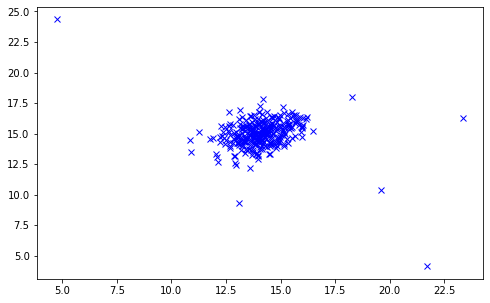

In [9]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.plot(X[:,0], X[:,1], 'bx')
    # plt.scatter(Xval[:,0], Xval[:,1], c=yval.flatten(), marker='x', cmap='rainbow')
    
plot_data()

### 1.1 Gaussian distribution

要执行异常检测，首先需要将模型拟合数据的分布。

给定训练集${x^{(1)}, ..., x^{(m)}}$, 我们想要对每个特征$x_i$ 做高斯分布估计。对于每个特征，$i = 1...n$，我们需要找到参数 $u_i, \delta^2_i$ 来拟合数据。

![image.png](../img/8_1.png)

![image.png](../img/8_2.png)

In [10]:
def gaussian(X, mu, sigma2):
    '''
    mu, sigma2参数已经决定了一个高斯分布模型
    因为原始模型就是多元高斯模型在sigma2上是对角矩阵而已，所以如下：
    If Sigma2 is a matrix, it is treated as the covariance matrix. 
    If Sigma2 is a vector, it is treated as the sigma^2 values of the variances
    in each dimension (a diagonal covariance matrix)
    output:
        一个(m, )维向量，包含每个样本的概率值。
    '''
# 如果想用矩阵相乘求解exp()中的项，一定要注意维度的变换。
# 事实上我们只需要取对角线上的元素即可。（类似于方差而不是想要协方差）
# 最后得到一个（m，）的向量，包含每个样本的概率，而不是想要一个（m,m）的矩阵
# 注意这里，当矩阵过大时，numpy矩阵相乘会出现内存错误。例如9万维的矩阵。所以画图时不能生成太多数据~！
#     n = len(mu) 
    
#     if np.ndim(sigma2) == 1:
#         sigma2 = np.diag(sigma2)

#     X = X - mu
#     p1 = np.power(2 * np.pi, -n/2)*np.sqrt(np.linalg.det(sigma2))
#     e = np.diag(X@np.linalg.inv(sigma2)@X.T)  # 取对角元素，类似与方差，而不要协方差
#     p2 = np.exp(-.5*e)
    
#     return p1 * p2

# 下面是不利用矩阵的解法，相当于把每行数据输入进去，不会出现内存错误。
    m, n = X.shape
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2) # 对角矩阵

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sigma2))) # np.linalg.det求行列式
    exp = np.zeros((m,1))
    for row in range(m):
        xrow = X[row]
        exp[row] = np.exp(-0.5*((xrow-mu).T).dot(np.linalg.inv(sigma2)).dot(xrow-mu))
    return norm*exp

### 1.2 Estimating parameters for a Gaussian

参数估计：
![image.png](../img/8_3.png)


In [11]:
def getGaussianParams(X, useMultivariate):
    """
    The input X is the dataset with each n-dimensional data point in one row
    The output is an n-dimensional vector mu, the mean of the data set 
    the variances sigma^2, an n x 1 vector 或者是(n,n)矩阵，if你使用了多元高斯函数
    作业这里求样本方差除的是 m 而不是 m - 1，实际上效果差不了多少。
    """
    mu = X.mean(axis=0)
    if useMultivariate:    
        sigma2 = ((X-mu).T @ (X-mu)) / len(X)  # using multivariate gaussian 
    else:
        sigma2 = X.var(axis=0, ddof=0)  # 样本方差
    
    return mu, sigma2

![image.png](../img/8_4.png)

In [12]:
def plotContours(mu, sigma2):
    """
    画出高斯概率分布的图，在三维中是一个上凸的曲面。投影到平面上则是一圈圈的等高线。
    """
    delta = .3  # 注意delta不能太小！！！否则会生成太多的数据，导致矩阵相乘会出现内存错误。
    x = np.arange(0,30,delta)  # numpy.arange([start, ]stop, [step, ]dtype=None)
    y = np.arange(0,30,delta)
    
    # 这部分要转化为X形式的坐标矩阵，也就是一列是横坐标，一列是纵坐标，
    # 然后才能传入gaussian中求解得到每个点的概率值
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]  # 按列合并，一列横坐标，一列纵坐标
    z = gaussian(points, mu, sigma2)
    z = z.reshape(xx.shape)  # 这步骤不能忘
    
    cont_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, z, cont_levels)  # 这个levels是作业里面给的参考,或者通过求解的概率推出来。

    plt.title('Gaussian Contours',fontsize=16)

https://stackoverflow.com/questions/24418980/mark-a-specific-level-in-contour-map-on-matplotlib

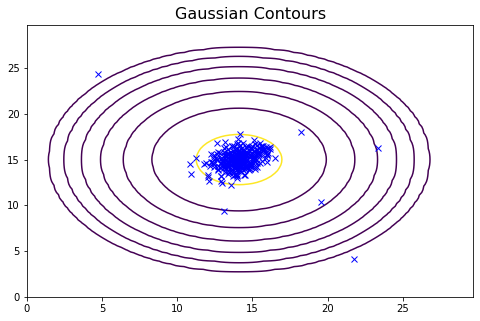

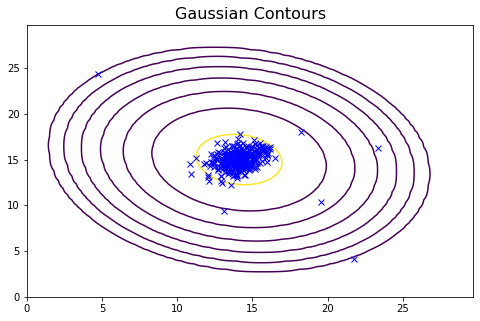

In [13]:
# First contours without using multivariate gaussian:
plot_data()
useMV = False
plotContours(*getGaussianParams(X, useMV))

# Then contours with multivariate gaussian:
plot_data()
useMV = True
# *表示解元组
plotContours(*getGaussianParams(X, useMV))

从上面的图可以看到，一元高斯模型仅在横向和纵向上有变化，而多元高斯模型在斜轴上也有相关变化，对应着特征间的相关关系。而一元高斯模型就是多元高斯模型中协方差矩阵为对角矩阵的结果，即协方差都为0，不考虑协方差，只考虑方差，故一元高斯模型不会有斜轴上的变化。

从上面的图我们可以清晰的看到，哪些样本的概率高，哪些样本的概率低，概率低的样本很大程度上就是异常值。

### 1.3 Selecting the threshold, ε

确定哪些例子是异常的一种方法是通过一组交叉验证集，选择一个好的阈值 ε 。

在这部分的练习中,您将实现一个算法使用交叉验证集的F1分数来选择合理的阈值 ε 。

![image.png](../img/8_5.png)

tp means true positives：是异常值，并且我们的模型预测成异常值了，即真的异常值。

fp means false positives：是正常值，但模型把它预测成异常值，即假的异常值。

fn means false negatives：是异常值，但是模型把它预测成正常值，即假的正常值。

precision 表示你预测为positive的样本中有多少是真的positive的样本。
recall 表示实际有多少positive的样本，而你成功预测出多少positive的样本。

y = 1 corresponds to an anomalous example, and y = 0 corresponds to a normal example.

In [15]:
def selectThreshold(yval, pval):
    def computeF1(yval, pval):
        m = len(yval)
        tp = float(len([i for i in range(m) if pval[i] and yval[i]]))
        fp = float(len([i for i in range(m) if pval[i] and not yval[i]]))
        fn = float(len([i for i in range(m) if not pval[i] and yval[i]]))
        prec = tp/(tp+fp) if (tp+fp) else 0
        rec = tp/(tp+fn) if (tp+fn) else 0
        F1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0
        return F1
   
    epsilons = np.linspace(min(pval), max(pval), 1000)
    bestF1, bestEpsilon = 0, 0
    for e in epsilons:
        pval_ = pval < e
        thisF1 = computeF1(yval, pval_)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEpsilon = e

    return bestF1, bestEpsilon

you should see a value epsilon of about 8.99e-05

you should see a Best F1 value of  0.875000

In [22]:
mu, sigma2 = getGaussianParams(X, useMultivariate=False)
pval = gaussian(Xval, mu, sigma2)
bestF1, bestEpsilon = selectThreshold(yval, pval)  
# (0.8750000000000001, 8.999852631901397e-05)

In [23]:
y = gaussian(X, mu, sigma2)  # X的概率
xx = np.array([X[i] for i in range(len(y)) if y[i] < bestEpsilon])
xx  # 离群点

array([[13.07931049,  9.34787812],
       [21.72713402,  4.12623222],
       [19.58257277, 10.411619  ],
       [23.33986753, 16.29887355],
       [18.26118844, 17.978309  ],
       [ 4.75261282, 24.35040725]])

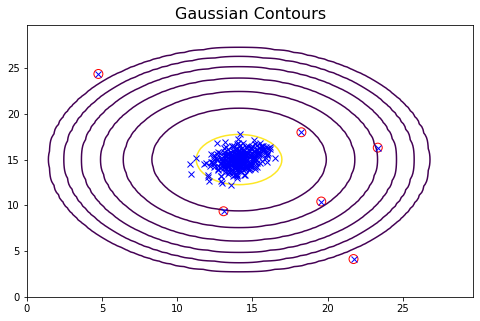

In [24]:
plot_data()
plotContours(mu, sigma2)
plt.scatter(xx[:,0], xx[:,1], s=80, facecolors='none', edgecolors='r')

### 1.4 High dimensional dataset

In [25]:
mat = loadmat( 'data/ex8data2.mat' )
X2 = mat['X']
Xval2, yval2 = mat['Xval'], mat['yval']
X2.shape

(1000, 11)

In [26]:
mu, sigma2 = getGaussianParams(X2, useMultivariate=False)
ypred = gaussian(X2, mu, sigma2)

yval2pred = gaussian(Xval2, mu, sigma2)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(yval2, yval2pred)
anoms = [X2[i] for i in range(X2.shape[0]) if ypred[i] < bestEps]
bestEps, len(anoms)

(array([1.3786075e-18]), 117)

## 2 Recommender Systems

实际上呢，这里使用的就是改良后的SVD矩阵分解算法。[矩阵分解在协同过滤推荐算法中的应用](http://www.cnblogs.com/pinard/p/6351319.html)

这一部分，将实现协同过滤学习算法，并将其应用于电影评分数据集。这个数据集由1到5的等级组成。数据集有$n_u$ = 943个用户，$n_m$ = 1682部电影。

### 2.1 Movie ratings dataset

矩阵Y(nm, nu)是不同电影的不同用户的评分，行数为电影数目，列数为用户数目。

矩阵R是二进制指示矩阵，R(i, j)=1 表示用户j 对电影i 有评分，R(i, j)=0 表示用户j对电影i没有评分。

协同过滤的目标是预测用户还没有评分的电影的评分，也就是R(i, j) = 0的项。这将允许我们向用户推荐预测收视率最高的电影。

![image.png](../img/8_6.png)

X第i行代表第i个电影的特征向量$x^{(i)}$，theta矩阵的第j列代表第j用户一个参数向量$\theta_{(j)}$。$x^{(i)}$ 和 $\theta^{(j)}$ 都是n维向量。

这个练习，我们取n=100(这里实际上已经做了降维分解)，所以，X is a ($n_m$, 100) matrix and $\theta$ is a ($n_u$, 100) matrix.

In [10]:
mat = loadmat('data/ex8_movies.mat')
print(mat.keys())
Y, R = mat['Y'], mat['R']
nm, nu = Y.shape  # Y中0代表用户没有评分
nf = 100
Y.shape, R.shape

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])


((1682, 943), (1682, 943))

先来求第一个电影的评分的平均值，注意有些人是没有评分这电影的。

In [11]:
Y[0].sum() / R[0].sum()  # 分子代表第一个电影的总分数，分母代表这部电影有多少评分数据

3.8783185840707963

Text(0.5, 0, 'Users (943)')

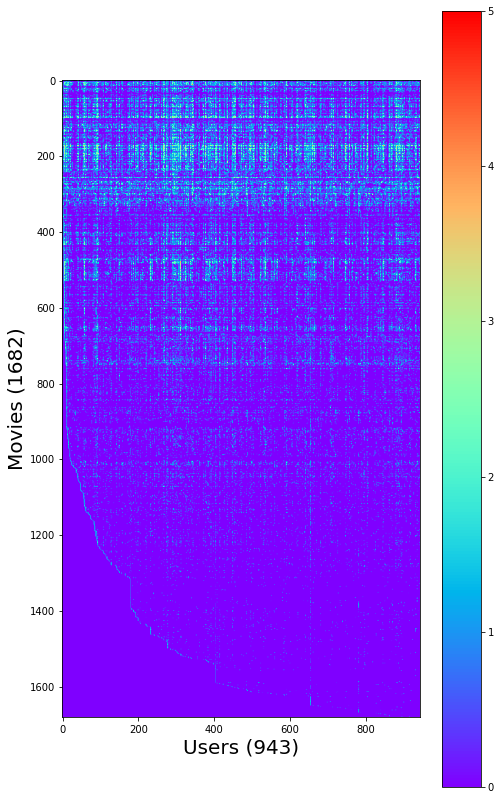

In [19]:
# "Visualize the ratings matrix"
fig = plt.figure(figsize=(8,8*(1682./943.)))
plt.imshow(Y, cmap='rainbow')
plt.colorbar()
plt.ylabel('Movies (%d)'%nm,fontsize=20)
plt.xlabel('Users (%d)'%nu,fontsize=20)

### 2.2 Collaborative filtering learning algorithm

这部分实现协同过滤算法，首先实现代价函数。

这里我们考虑对每一个参数$x^{(1...n_m)}\;and\;\theta^{(1...n_u)}$，都是一个n维的向量，这个n我们选取100。用户j对电影i的评分表示为$y^{(i,j)}=(\theta^{(\;j\;)})^Tx^{(i)}$，给定一个评分数据集，我们想要学习出 $x^{(1)},...,x^{(n_m)}\;and\;\theta^{(1)},...,\theta^{(n_u)}$，使代价函数最小。

也就是X矩阵，和θ矩阵。

为了使用高级优化算法，我们要将X和θ的参数量结合成一维的数组传入，在函数中再分解。

In [20]:
mat = loadmat('data/ex8_movieParams.mat')
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])
# For now, reduce the data set size so that this runs faster
nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

In [21]:
X.shape, Theta.shape

((5, 3), (4, 3))

#### 2.2.1 Collaborative filtering cost function

协同过滤的参数都不需要加偏置项了，故都可以正则化。

![image.png](../img/8_7.png)


In [22]:
def serialize(X, Theta):
    '''展开参数'''
    return np.r_[X.flatten(),Theta.flatten()]

In [24]:
def deserialize(seq, nm, nu, nf):
    '''提取参数'''
    return seq[:nm*nf].reshape(nm, nf), seq[nm*nf:].reshape(nu, nf)

In [25]:
def cofiCostFunc(params, Y, R, nm, nu, nf, l=0):
    """
    params : 拉成一维之后的参数向量(X, Theta)
    Y : 评分矩阵 (nm, nu)
    R ：0-1矩阵，表示用户对某一电影有无评分
    nu : 用户数量
    nm : 电影数量
    nf : 自定义的特征的维度
    l : lambda for regularization
    """
    X, Theta = deserialize(params, nm, nu, nf)
    
    # (X@Theta)*R含义如下： 因为X@Theta是我们用自定义参数算的评分，但是有些电影本来是没有人
    # 评分的，存储在R中，0-1表示。将这两个相乘，得到的值就是我们要的已经被评分过的电影的预测分数。
    error = 0.5*np.square((X@Theta.T - Y)*R).sum()
    reg1 = .5*l*np.square(Theta).sum()
    reg2 = .5*l*np.square(X).sum()
    
    return error + reg1 + reg2

In [26]:
cofiCostFunc(serialize(X,Theta),Y,R,nm,nu,nf),cofiCostFunc(serialize(X,Theta),Y,R,nm,nu,nf,1.5)

(22.224603725685675, 31.34405624427422)

#### 2.2.2 Collaborative filtering gradient

![image.png](../img/8_8.png)


In [27]:
def cofiGradient(params, Y, R, nm, nu, nf, l=0):
    """
    计算X和Theta的梯度，并序列化输出。
    """
    X, Theta = deserialize(params, nm, nu, nf)
    
    X_grad = ((X@Theta.T-Y)*R)@Theta + l*X
    Theta_grad = ((X@Theta.T-Y)*R).T@X + l*Theta
    
    return serialize(X_grad, Theta_grad)

In [28]:
def checkGradient(params, Y, myR, nm, nu, nf, l = 0.):
    """
    Let's check my gradient computation real quick
    """
    print('Numerical Gradient \t cofiGrad \t\t Difference')
    
    # 分析出来的梯度
    grad = cofiGradient(params,Y,myR,nm,nu,nf,l)
    
    # 用 微小的e 来计算数值梯度。
    e = 0.0001
    nparams = len(params)
    e_vec = np.zeros(nparams)

    # Choose 10 random elements of param vector and compute the numerical gradient
    # 每次只能改变e_vec中的一个值，并在计算完数值梯度后要还原。
    for i in range(10):
        idx = np.random.randint(0,nparams)
        e_vec[idx] = e
        loss1 = cofiCostFunc(params-e_vec,Y,myR,nm,nu,nf,l)
        loss2 = cofiCostFunc(params+e_vec,Y,myR,nm,nu,nf,l)
        numgrad = (loss2 - loss1) / (2*e)
        e_vec[idx] = 0
        diff = np.linalg.norm(numgrad - grad[idx]) / np.linalg.norm(numgrad + grad[idx])
        print('%0.15f \t %0.15f \t %0.15f' %(numgrad, grad[idx], diff))

In [29]:
print("Checking gradient with lambda = 0...")
checkGradient(serialize(X,Theta), Y, R, nm, nu, nf)
print("\nChecking gradient with lambda = 1.5...")
checkGradient(serialize(X,Theta), Y, R, nm, nu, nf, l=1.5)

Checking gradient with lambda = 0...
Numerical Gradient 	 cofiGrad 		 Difference
2.263336983929776 	 2.263336983921972 	 0.000000000001724
-0.803780061460202 	 -0.803780061452057 	 0.000000000005067
-0.568195965513496 	 -0.568195965515757 	 0.000000000001990
3.352650312855587 	 3.352650312849549 	 0.000000000000901
1.164413669449971 	 1.164413669446225 	 0.000000000001609
0.000000000000000 	 0.000000000000000 	 nan
-0.568195965513496 	 -0.568195965515757 	 0.000000000001990
4.627760190007990 	 4.627760190006159 	 0.000000000000198
0.000000000000000 	 0.000000000000000 	 nan
7.575703079698570 	 7.575703079709334 	 0.000000000000710

Checking gradient with lambda = 1.5...
Numerical Gradient 	 cofiGrad 		 Difference
-0.955963393440840 	 -0.955963393432561 	 0.000000000004330
0.602526771817935 	 0.602526771833594 	 0.000000000012994
1.092897577699148 	 1.092897577688307 	 0.000000000004960
-6.765636277386022 	 -6.765636277366185 	 0.000000000001466
1.063009327584297 	 1.063009327570006 	 0

<ipython-input-28-f16d4e1d01d1>:24: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(numgrad - grad[idx]) / np.linalg.norm(numgrad + grad[idx])


### 2.3 Learning movie recommendations

在我们训练协同过滤模型之前，我们先要获取所有电影的名称以及 添加与我们刚才观察到的新用户对应的评分。

In [30]:
movies = []  # 包含所有电影的列表
with open('data/movie_ids.txt','r', encoding='utf-8') as f:
    for line in f:
#         movies.append(' '.join(line.strip().split(' ')[1:]))
        movies.append(' '.join(line.strip().split(' ')[1:]))

movies

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)',
 'Seven (Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Mighty Aphrodite (1995)',
 'Postino, Il (1994)',
 "Mr. Holland's Opus (1995)",
 'French Twist (Gazon maudit) (1995)',
 'From Dusk Till Dawn (1996)',
 'White Balloon, The (1995)',
 "Antonia's Line (1995)",
 'Angels and Insects (1995)',
 'Muppet Treasure Island (1996)',
 'Braveheart (1995)',
 'Taxi Driver (1976)',
 'Rumble in the Bronx (1995)',
 'Birdcage, The (1996)',
 'Brothers McMullen, The (1995)',
 'Bad Boys (1995)',
 'Apollo 13 (1995)',
 'Batman Forever (1995)',
 'Belle de jour (1967)',
 'Crimson Tide (1995)',
 'Crumb (1994)',
 'Desperado (1995)',
 'Doom Generation, The (1995)',
 'Free Willy 2: The Adventure Home (1995)',
 'Mad Love (1995)',
 'Nadja (1994)',
 'Net, The (1995

In [31]:
my_ratings = np.zeros((1682,1))

my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(my_ratings[i], movies[i])

[4.] Toy Story (1995)
[3.] Twelve Monkeys (1995)
[5.] Usual Suspects, The (1995)
[4.] Outbreak (1995)
[5.] Shawshank Redemption, The (1994)
[3.] While You Were Sleeping (1995)
[5.] Forrest Gump (1994)
[2.] Silence of the Lambs, The (1991)
[4.] Alien (1979)
[5.] Die Hard 2 (1990)
[5.] Sphere (1998)


导入Y矩阵以及R矩阵

In [33]:
mat = loadmat('data/ex8_movies.mat')
Y, R = mat['Y'], mat['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

将我们刚才添加的新用户数据合并到Y 和R

In [34]:
Y = np.c_[Y, my_ratings]  # (1682, 944)
R = np.c_[R, my_ratings!=0]  # (1682, 944)
nm, nu = Y.shape

In [40]:
nf = 10 # 我们使用10维的特征向量

均值归一化数据，这个可以使一个完全没有评分的的特征最后也会获得非零值。是因为，最后要加回均值。

注意只对有评分的数据求均值，没有评分的数据不包含在内，要用R矩阵判断。

In [41]:
def normalizeRatings(Y, R):
    """
    The mean is only counting movies that were rated
    """
    Ymean = (Y.sum(axis=1) / R.sum(axis=1)).reshape(-1,1)
#     Ynorm = (Y - Ymean)*R  # 这里也要注意不要归一化未评分的数据
    Ynorm = (Y - Ymean)*R  # 这里也要注意不要归一化未评分的数据
    return Ynorm, Ymean

In [42]:
Ynorm, Ymean = normalizeRatings(Y, R)
Ynorm.shape, Ymean.shape

((1682, 944), (1682, 1))

生成初始化参数X矩阵，Theta矩阵

In [43]:
X = np.random.random((nm, nf))
Theta = np.random.random((nu, nf))
params = serialize(X, Theta)
l = 10

In [44]:
import scipy.optimize as opt
res = opt.minimize(fun=cofiCostFunc,
                   x0=params,
                   args=(Y, R, nm, nu, nf, l),
                   method='TNC',
                   jac=cofiGradient,
                   options={'maxiter': 100})

ret = res.x

In [45]:
# import scipy.optimize as opt
# ret = opt.fmin_cg(cofiCostFunc, x0=params, fprime=cofiGradient, 
#                   args=(Y, R, nm, nu, nf, l), maxiter=100)

In [46]:
fit_X, fit_Theta = deserialize(ret, nm, nu, nf)

#### 2.3.1 Recommendations

现在我们就可以利用训练好的参数来预测用户的分数。

In [47]:
# 所有用户的剧场分数矩阵
pred_mat = fit_X @ fit_Theta.T

In [48]:
# 最后一个用户的预测分数， 也就是我们刚才添加的用户
pred = pred_mat[:,-1] + Ymean.flatten()

In [49]:
max(pred)

8.479138874421698

In [50]:
pred_sorted_idx = np.argsort(pred)[::-1] # 排序并翻转，使之从大到小排列

作业中最后的截图应该是算错了，用的是非归一化的数据Y来训练的。所以我在这里也在这里用的非归一化的数据Y来训练的。事实上应该用归一化之后的数据Ynorm来训练，可自行尝试。

In [51]:
print("Top recommendations for you:")
for i in range(10):
    print('Predicting rating %0.1f for movie %s.' \
          %(pred[pred_sorted_idx[i]],movies[pred_sorted_idx[i]]))

print("\nOriginal ratings provided:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for movie %s.'% (my_ratings[i],movies[i]))
    

Top recommendations for you:
Predicting rating 8.5 for movie Star Wars (1977).
Predicting rating 8.4 for movie Shawshank Redemption, The (1994).
Predicting rating 8.2 for movie Schindler's List (1993).
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.2 for movie Titanic (1997).
Predicting rating 8.2 for movie Close Shave, A (1995).
Predicting rating 8.1 for movie Casablanca (1942).
Predicting rating 8.1 for movie Wrong Trousers, The (1993).
Predicting rating 8.1 for movie Empire Strikes Back, The (1980).
Predicting rating 8.1 for movie Usual Suspects, The (1995).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 for movi